<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

## Regression and Classification with the Ames Housing Data

## Modelling - Part 1 and Part 2

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import useful_functions

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor

In [3]:
# Load the data
df = pd.read_csv('housing_clean.csv')
df.shape

(1442, 80)

In [4]:
# convert MoSold and MSSubClass to strings to be used as categorical variables
df.MoSold = df.MoSold.astype(str)
df.MSSubClass = df.MSSubClass.astype(str)

In [5]:
# there are 122 rows with SaleCondition of Partial
# remove these rows since Partial sales are on new homes which have not been completed
# so they are probably not relevant for our analysis (you would not renovate a new home)
df_1 = df[df.SaleCondition != 'Partial'].copy()
df_1.shape

(1320, 80)

In [6]:
# define lists of fixed features and renovateable features
fixed_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
                  'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
                  'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                  'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'Foundation', 
                  'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                  'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                  'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageCars', 
                  'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                  '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal']

renovateable_features = ['Utilities', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
                         'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond',
                         'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
                         'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                         'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

len(fixed_features), len(renovateable_features)

(50, 24)

### Part 1: Modelling - Fixed Features

In [7]:
# dummify categorical variables including NaN as a category
X_1 = pd.get_dummies(df_1[fixed_features], dummy_na=True, drop_first=True)
X_1.shape

(1320, 154)

In [8]:
# do train-test split
X_1_train = pd.DataFrame(X_1[df_1.YrSold < 2010], columns=X_1.columns)
X_1_test = pd.DataFrame(X_1[df_1.YrSold == 2010], columns=X_1.columns)

y_1_train = df_1.SalePrice[df_1.YrSold < 2010]
y_1_test = df_1.SalePrice[df_1.YrSold == 2010]
X_1_train.shape, X_1_test.shape, y_1_train.shape, y_1_test.shape

((1156, 154), (164, 154), (1156,), (164,))

In [9]:
# standardize the data
scaler = StandardScaler()
X_1_train = pd.DataFrame(scaler.fit_transform(X_1_train), columns=X_1_train.columns)
X_1_test = pd.DataFrame(scaler.transform(X_1_test), columns=X_1_test.columns)

In [10]:
# functions for log transformation
def func(x):
    return np.log(x)
def inverse_func(x):
    return np.exp(x)

### Linear regression model

In [11]:
lr_1 = LinearRegression()
# shuffle the data for the cross-validation as it is still in original order
kf = KFold(n_splits=5, shuffle=True, random_state=1)
lr_1_scores = useful_functions.model_fitter(lr_1, X_1_train, y_1_train, X_1_test, y_1_test, cv=kf)

Mean cross-validated training score:  -1.7094789670173716e+23
Training score:  0.9074076779919357
Test score:  0.8857157631093373


### Comment on linear regression model
The mean cross-validated R^2 score is huge and negative. It is likely that the model is overfitting and there are redundant variables affecting it. There is likely multicollinearity between some of the variables.  
It is not possible to use TransformedTargetRegressor to do a log transformation on the sale price in this case.     
> Next steps: look at regularization using Ridge, Lasso and ElasticNet.

### Ridge model

#### With log transformation

In [12]:
# find optimal value for alpha in Ridge model
optimal_ridge_1_log = TransformedTargetRegressor(regressor=RidgeCV(alphas=np.logspace(0, 5, 200), cv=10),
                                                 func=func, inverse_func=inverse_func, check_inverse=False)
optimal_ridge_1_log.fit(X_1_train, y_1_train)
print(optimal_ridge_1_log.regressor_.alpha_)

102.34114021054538


In [13]:
ridge_1_log = TransformedTargetRegressor(regressor=Ridge(alpha=optimal_ridge_1_log.regressor_.alpha_),
                                         func=func, inverse_func=inverse_func, check_inverse=False)
ridge_1_log_scores = useful_functions.model_fitter(ridge_1_log, X_1_train, y_1_train, X_1_test, y_1_test, cv=kf)

Mean cross-validated training score:  0.9000105088395977
Training score:  0.931305664868571
Test score:  0.8894298600171641


#### Without log transformation

In [14]:
# find optimal value for alpha in Ridge model
optimal_ridge_1 = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)
optimal_ridge_1.fit(X_1_train, y_1_train)
print(optimal_ridge_1.alpha_)

45.5293507486695


In [15]:
ridge_1 = Ridge(alpha=optimal_ridge_1.alpha_)                                    
ridge_1_scores = useful_functions.model_fitter(ridge_1, X_1_train, y_1_train, X_1_test, y_1_test, cv=kf)

Mean cross-validated training score:  0.857934014317639
Training score:  0.9043768764072525
Test score:  0.888940778112033


#### Look at coefficients from model with log transformation

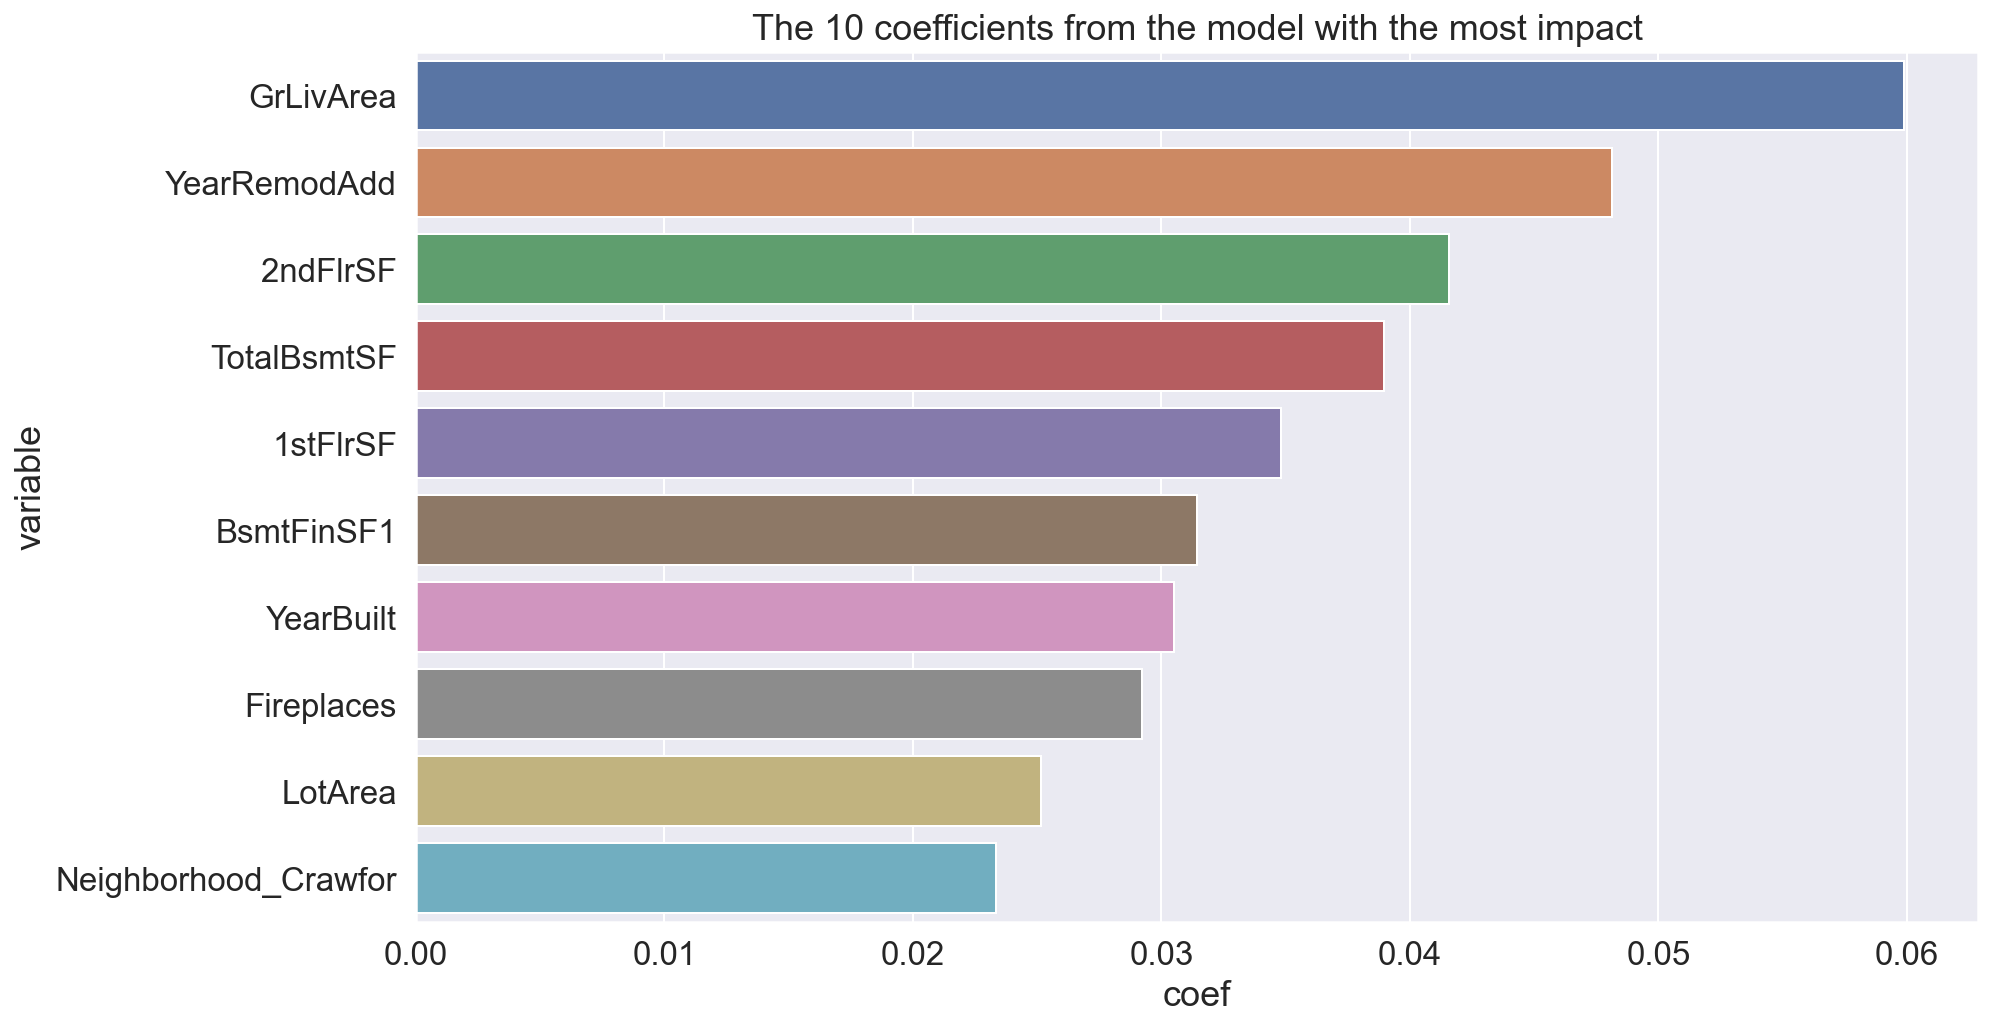

In [16]:
df_coef_r1, fig_r1 = useful_functions.plot_coefficients(ridge_1_log.regressor_, X_1.columns)

### Lasso model

#### With log transformation

In [17]:
# find optimal value for alpha in Lasso model
optimal_lasso_1_log = TransformedTargetRegressor(regressor=LassoCV(n_alphas=500, cv=10, n_jobs=-2),
                                                 func=func, inverse_func=inverse_func, check_inverse=False)
optimal_lasso_1_log.fit(X_1_train, y_1_train)
print(optimal_lasso_1_log.regressor_.alpha_)

0.002962921070016076


In [18]:
lasso_1_log = TransformedTargetRegressor(regressor=Lasso(alpha=optimal_lasso_1_log.regressor_.alpha_),
                                         func=func, inverse_func=inverse_func, check_inverse=False)
lasso_1_log_scores = useful_functions.model_fitter(lasso_1_log, X_1_train, y_1_train, X_1_test, y_1_test, cv=kf)

Mean cross-validated training score:  0.904264933334367
Training score:  0.9257154716640764
Test score:  0.8931853218948056


#### Without log transformation

In [19]:
# find optimal value for alpha in Lasso model
optimal_lasso_1 = LassoCV(n_alphas=500, cv=10, n_jobs=-2)
optimal_lasso_1.fit(X_1_train, y_1_train)
print(optimal_lasso_1.alpha_)

302.0903149238432


In [20]:
lasso_1 = Lasso(alpha=optimal_lasso_1.alpha_)
lasso_1_scores = useful_functions.model_fitter(lasso_1, X_1_train, y_1_train, X_1_test, y_1_test, cv=kf)

Mean cross-validated training score:  0.8653056848113
Training score:  0.9024758085991095
Test score:  0.8904425349171297


#### Look at coefficients from model with log transformation

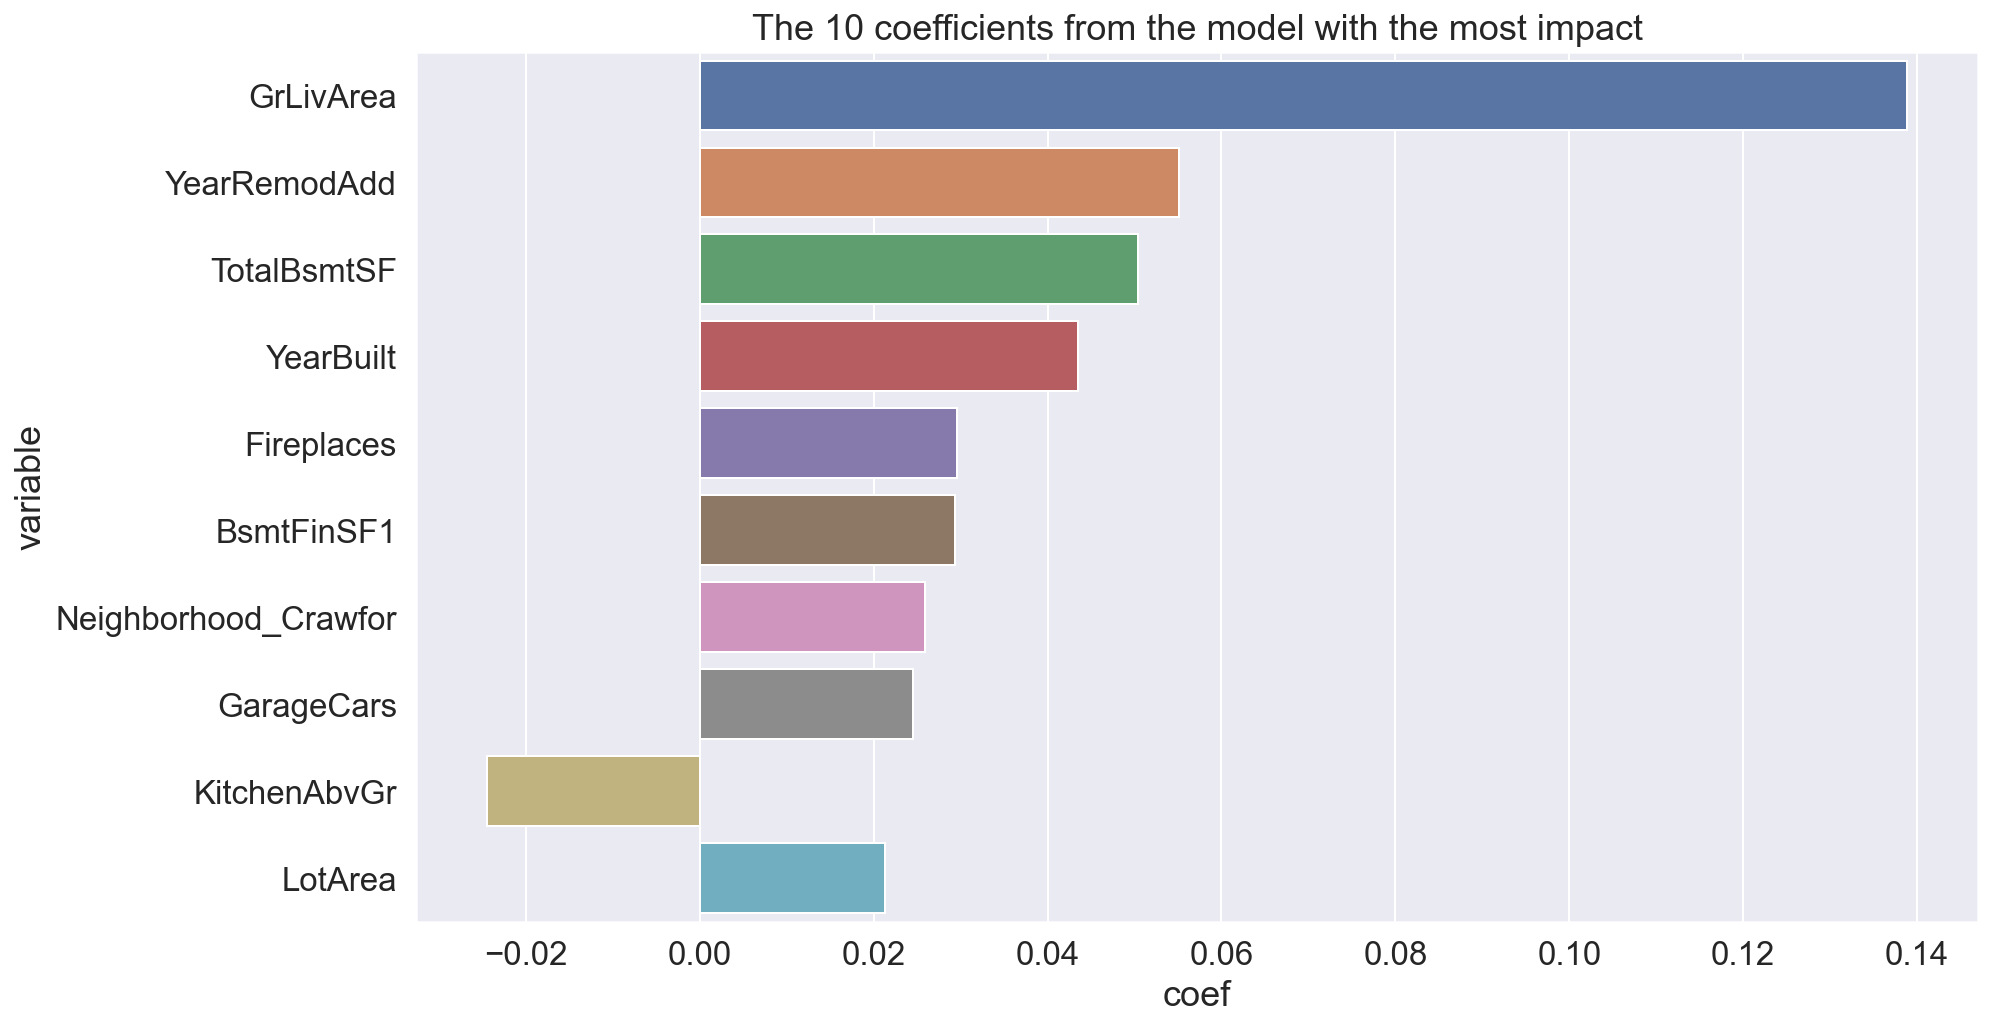

In [21]:
df_coef_l1, fig_l1 = useful_functions.plot_coefficients(lasso_1_log.regressor_, X_1.columns)

In [22]:
# % of coefficients == 0
print('Percent variables zeroed out:', np.sum((np.abs(lasso_1_log.regressor_.coef_) == 0))/float(X_1.shape[1]))

Percent variables zeroed out: 0.512987012987013


### ElasticNet model

#### With log transformation

In [23]:
# find optimal value for alpha and l1 ratio in ElasticNet model
optimal_en_1_log = TransformedTargetRegressor(regressor=ElasticNetCV(alphas=np.logspace(-5, 5, 10), 
                                                        l1_ratio=np.array([0.00001, .1, .5, .7, .9, .95, .99, 1]), 
                                                        cv=5, max_iter=1000000, n_jobs=-2),
                                              func=func, inverse_func=inverse_func, check_inverse=False)
optimal_en_1_log.fit(X_1_train, y_1_train)
print("Best alpha: ", optimal_en_1_log.regressor_.alpha_)
print("Best l1 ratio: ", optimal_en_1_log.regressor_.l1_ratio_)

Best alpha:  0.021544346900318846
Best l1 ratio:  0.1


In [24]:
enet_1_log = TransformedTargetRegressor(regressor=ElasticNet(alpha=optimal_en_1_log.regressor_.alpha_, 
                                                             l1_ratio=optimal_en_1_log.regressor_.l1_ratio_),
                                        func=func, inverse_func=inverse_func, check_inverse=False)
enet_1_log_scores = useful_functions.model_fitter(enet_1_log, X_1_train, y_1_train, X_1_test, y_1_test, cv=kf)

Mean cross-validated training score:  0.9040222903258945
Training score:  0.9275858258333611
Test score:  0.8928742461527611


#### Without log transformation

In [25]:
# find optimal value for alpha and l1 ratio in ElasticNet model
optimal_en_1 = ElasticNetCV(alphas=np.logspace(-5, 5, 10), 
                            l1_ratio=np.array([0.00001, .1, .5, .7, .9, .95, .99, 1]), 
                            cv=5, max_iter=5000000, n_jobs=-2)
optimal_en_1.fit(X_1_train, y_1_train)
print("Best alpha: ", optimal_en_1.alpha_)
print("Best l1 ratio: ", optimal_en_1.l1_ratio_)

/Users/julia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106848904154.81113, tolerance: 437179806.3341801
  model = cd_fast.enet_coordinate_descent_gram(
/Users/julia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161242626397.81955, tolerance: 455827874.4101028
  model = cd_fast.enet_coordinate_descent_gram(
/Users/julia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137085273996.55777, tolerance: 507598718.84653896
  model = cd_fast.enet_coordinate_descent_gram(
/Users/julia/opt/anaconda3/lib/python3.8/site-packages

Best alpha:  599.4842503189421
Best l1 ratio:  1.0


In [26]:
enet_1 = ElasticNet(alpha=optimal_en_1.alpha_, l1_ratio=optimal_en_1.l1_ratio_)
enet_1_scores = useful_functions.model_fitter(enet_1, X_1_train, y_1_train, X_1_test, y_1_test, cv=kf)

Mean cross-validated training score:  0.8653962176069255
Training score:  0.8962416755896446
Test score:  0.8884470905775366


#### Look at coefficients from model with log transformation

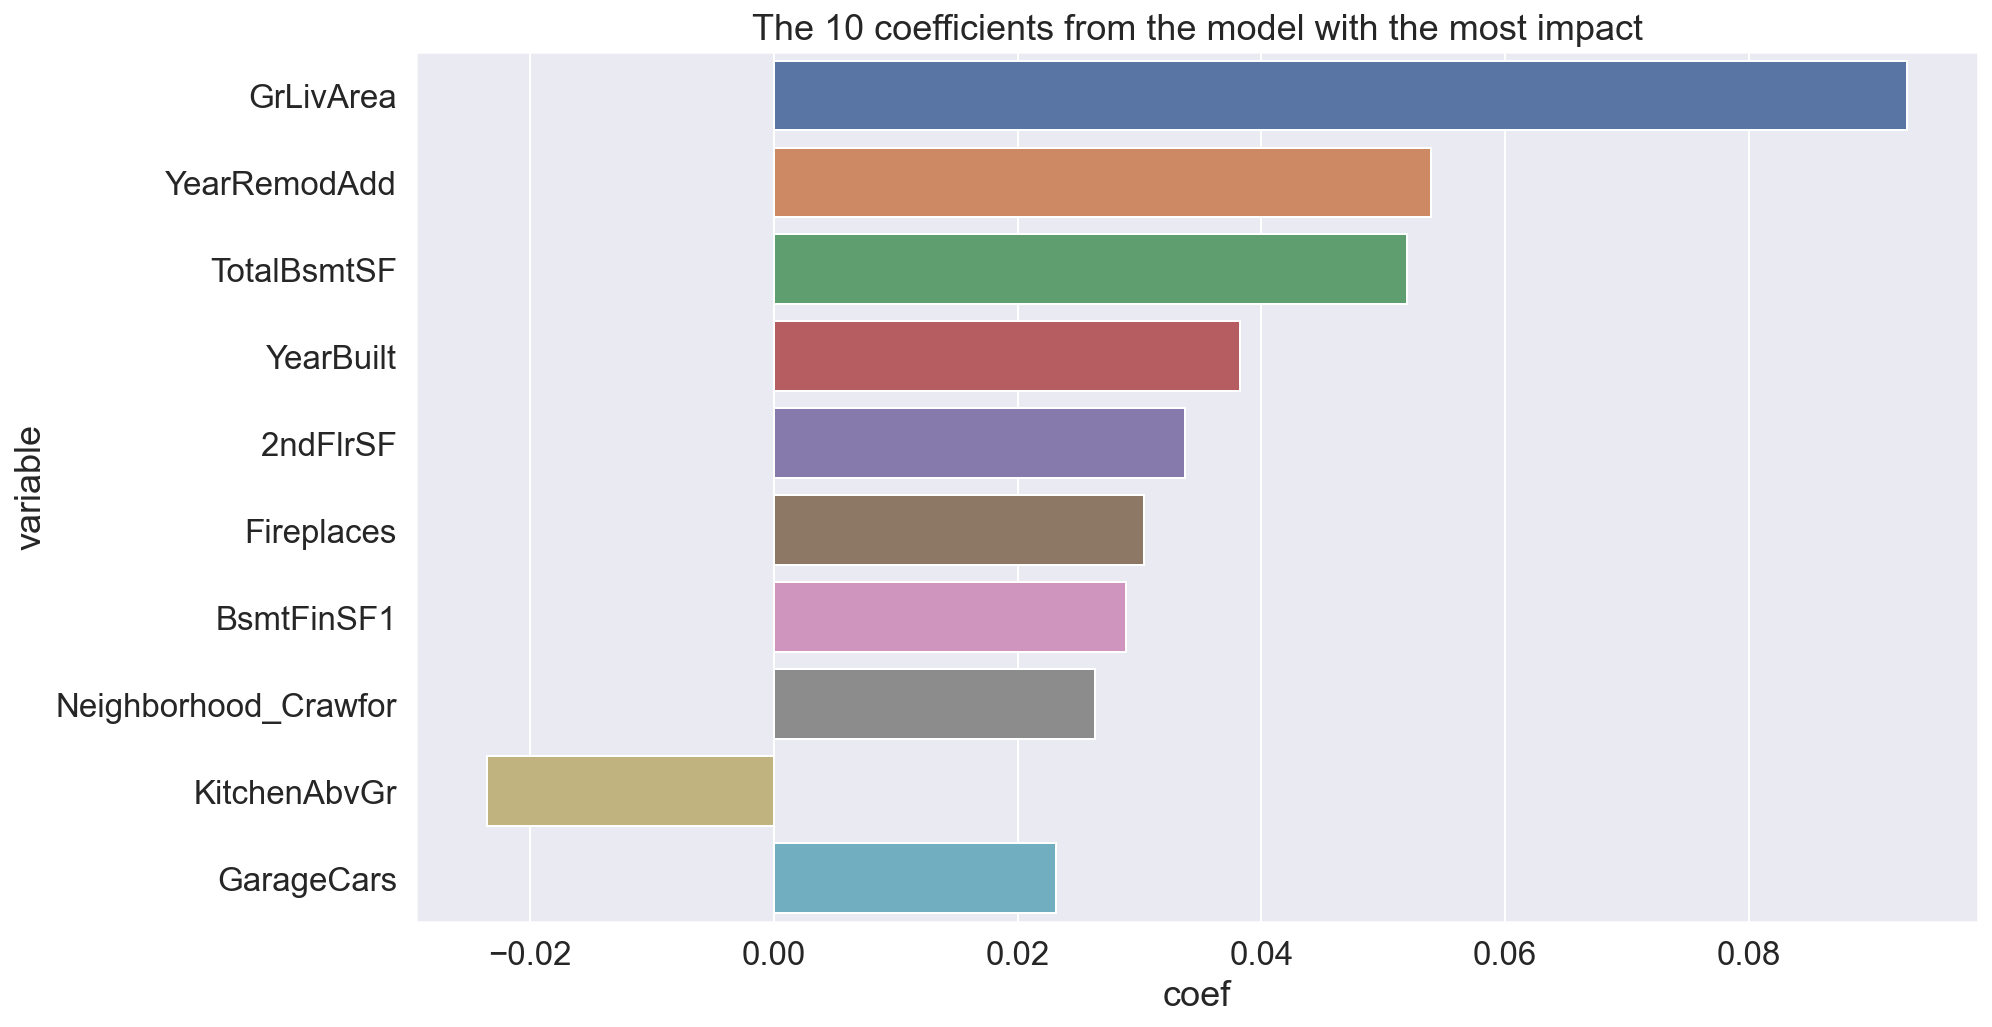

In [27]:
df_coef_en1, fig_en1 = useful_functions.plot_coefficients(enet_1_log.regressor_, X_1.columns)

### Results

In [28]:
# collect scores in a DataFrame
df_scores_1 = pd.DataFrame([ridge_1_log_scores, ridge_1_scores, 
                            lasso_1_log_scores, lasso_1_scores, 
                            enet_1_log_scores, enet_1_scores], 
                           columns=['Mean CV score', 'Training score', 'Test score'])
df_scores_1.insert(0, 'Model', ['Ridge (log transformation)', 'Ridge (no transformation)', 
                                'Lasso (log transformation)', 'Lasso (no transformation)', 
                                'ElasticNet (log transformation)', 'ElasticNet (no transformation)'])
df_scores_1

,Model,Mean CV score,Training score,Test score
0,Ridge (log transformation),0.900011,0.931306,0.889430
1,Ridge (no transformation),0.857934,0.904377,0.888941
2,Lasso (log transformation),0.904265,0.925715,0.893185
3,Lasso (no transformation),0.865306,0.902476,0.890443
4,ElasticNet (log transformation),0.904022,0.927586,0.892874
5,ElasticNet (no transformation),0.865396,0.896242,0.888447


Each of the Ridge, Lasso and ElasticNet models performs a lot better than the linear regression model. The regularization is necessary to reduce the multicollinearity and get a stable model which performs well under cross-validation. The results from the models (with and without log transformation of the target variable) are summarized in the DataFrame above and the bar chart below. 

The Lasso model has the highest R^2 score in the cross-validation and on the test data but there is not much difference between the 3 models. Using a log transformation on the target variable improves the mean cross-validated score by approximately 0.04.   

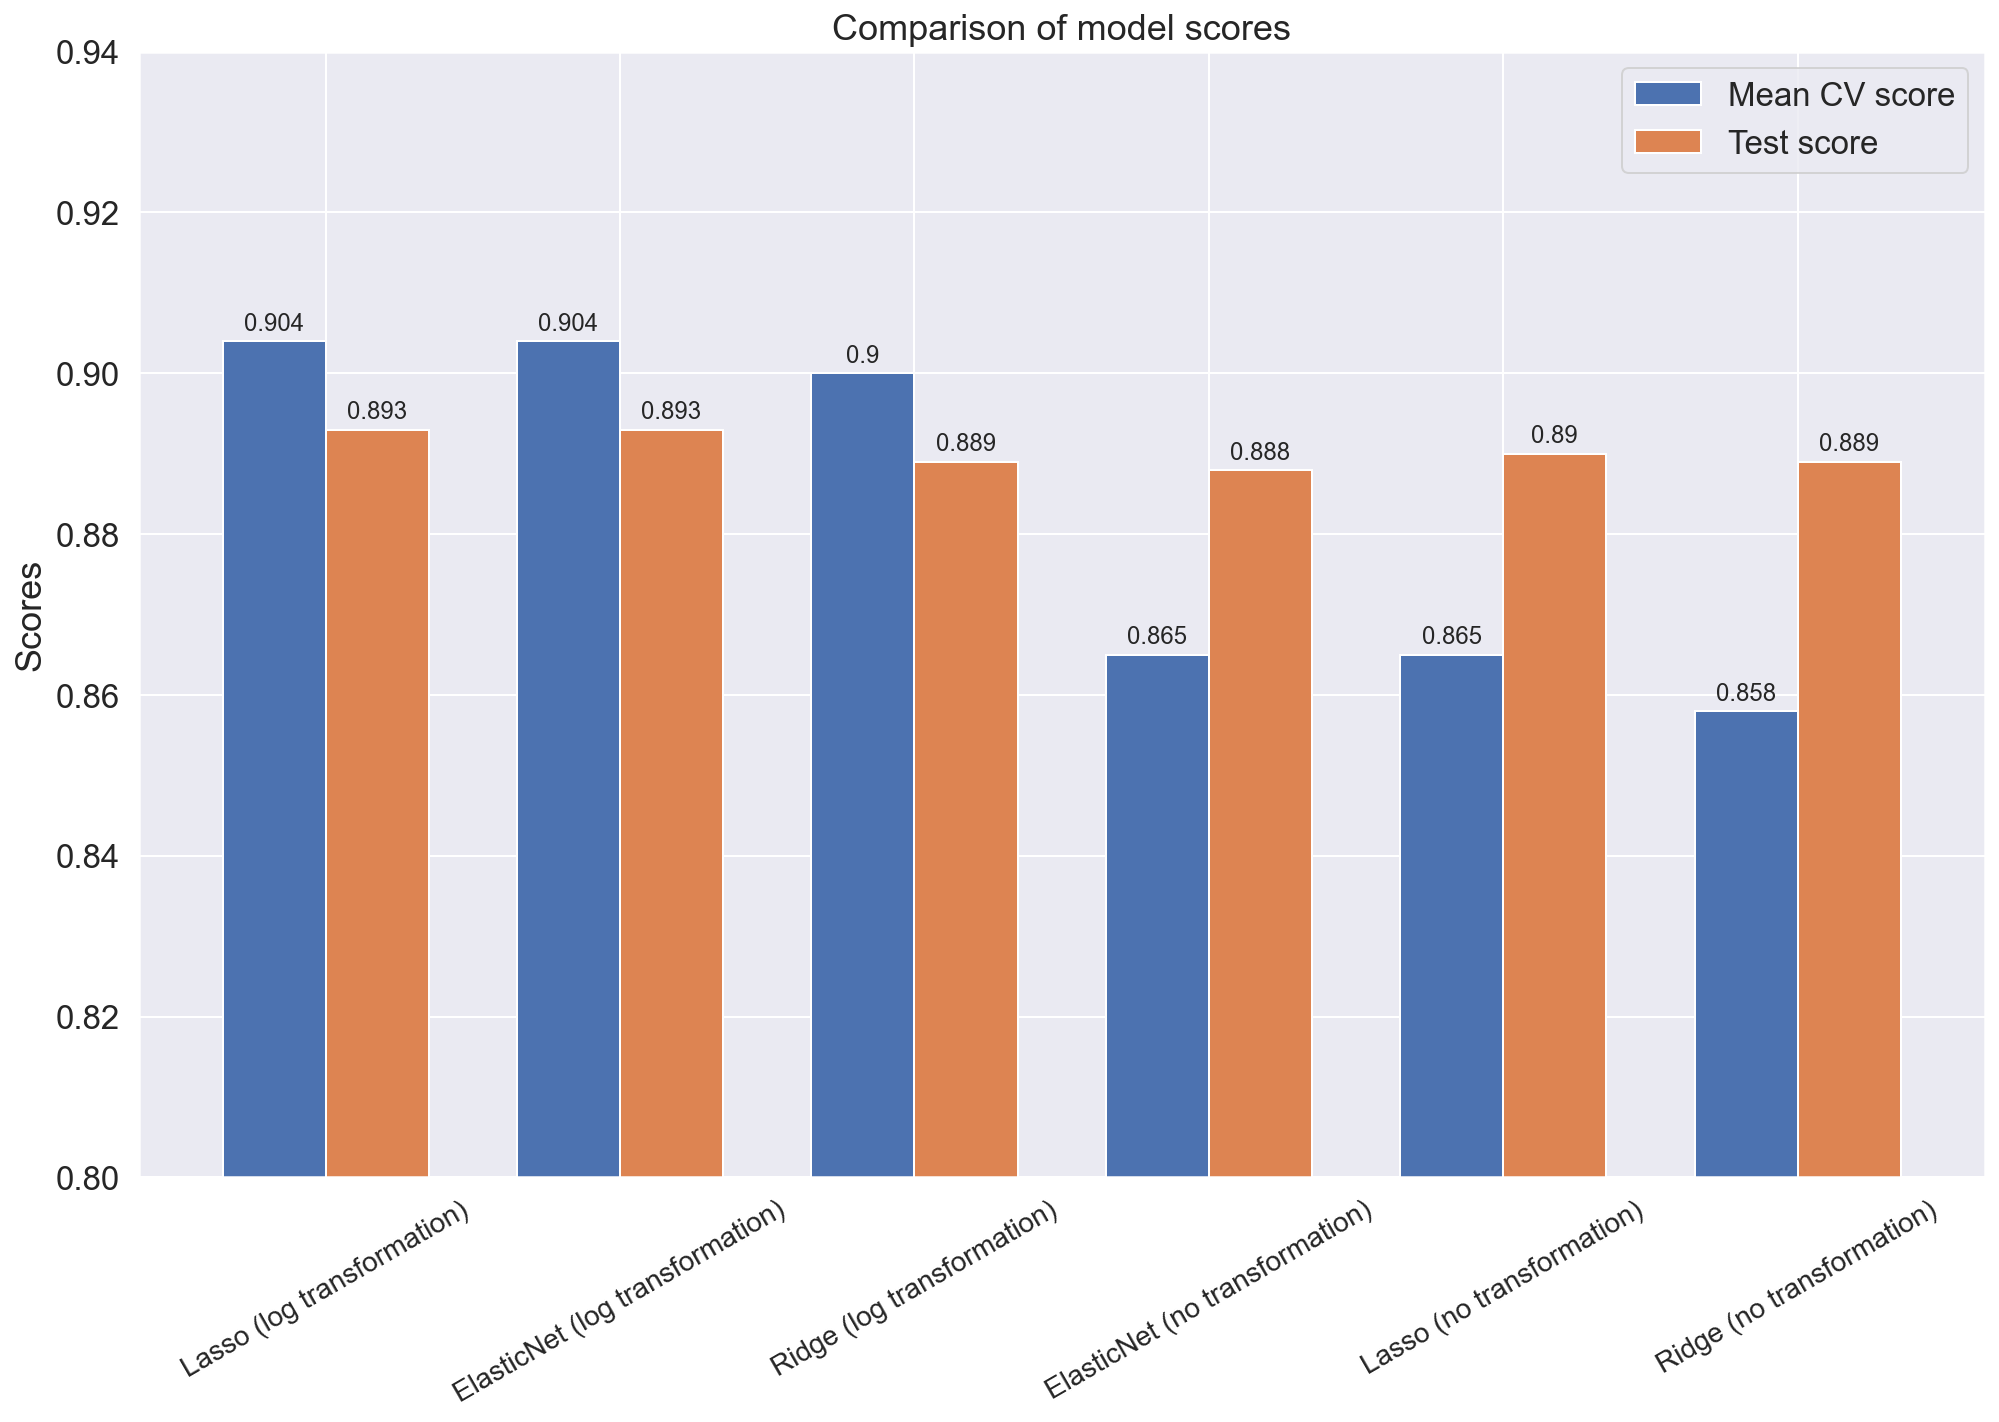

In [29]:
useful_functions.plot_model_scores(df_scores_1, 'Mean CV score', 'Test score', 'Model', 'Mean CV score', 'Test score',
                                   y_min=0.8, y_max=0.94)

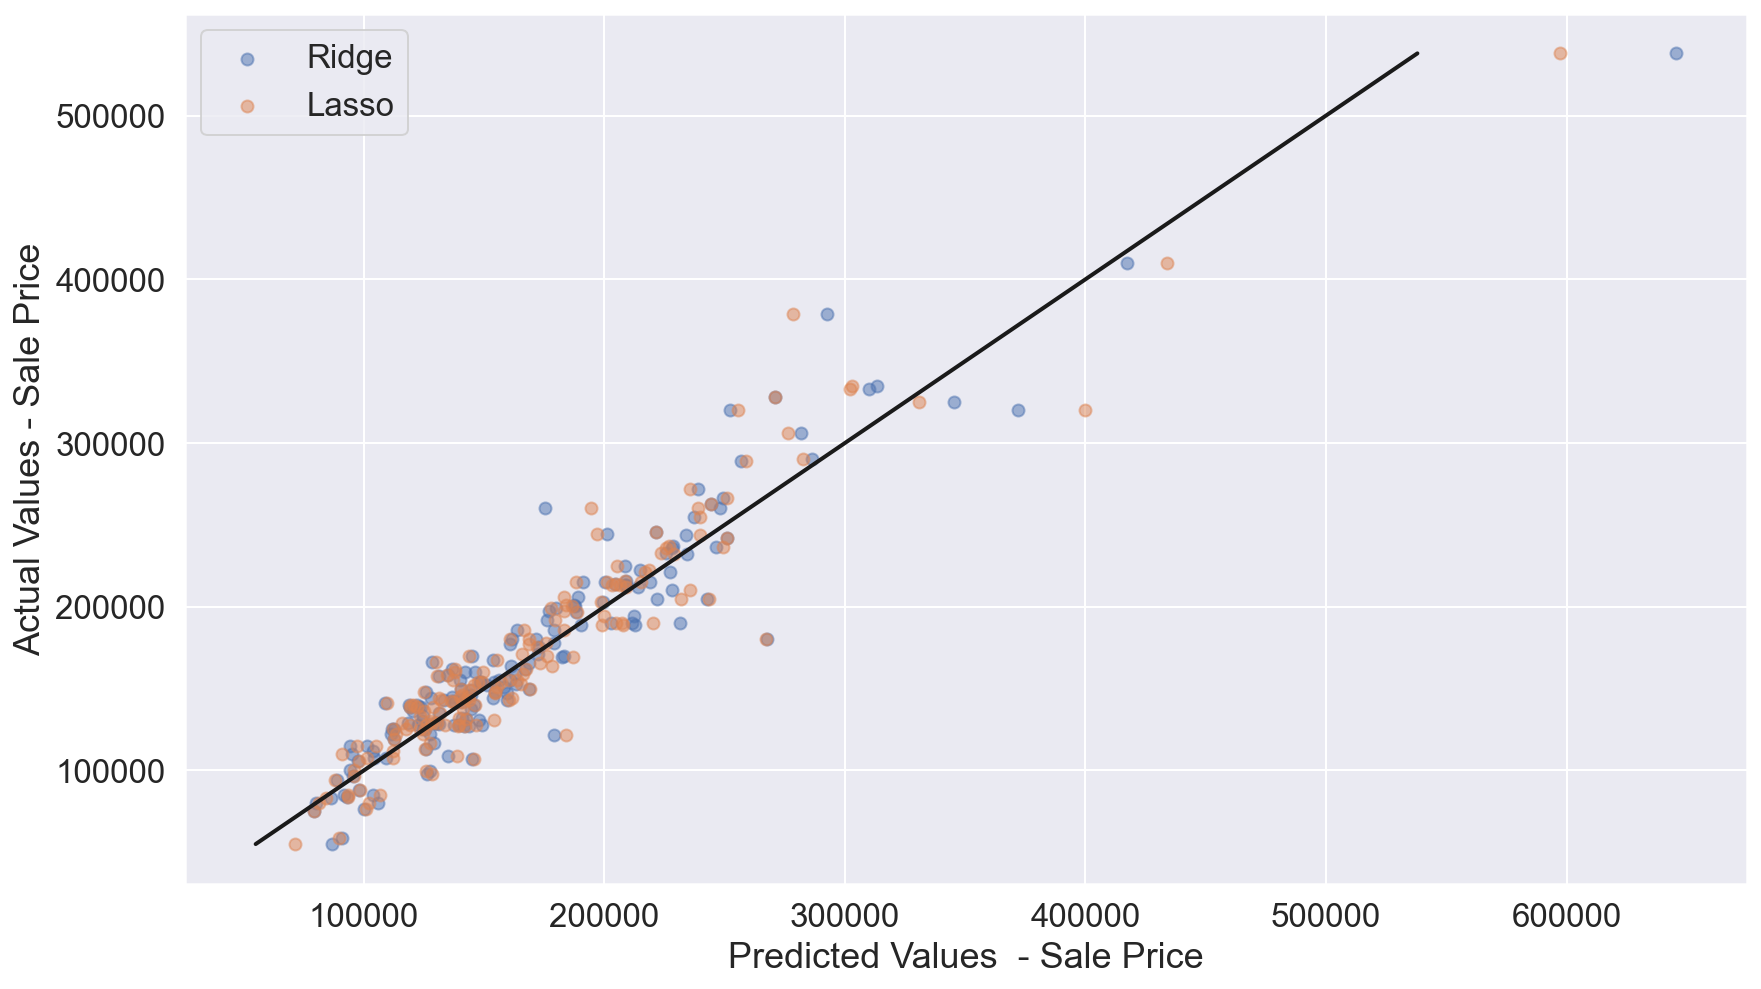

In [30]:
# plot Ridge and Lasso models (with log transformation)
plt.figure(figsize=(14, 8))
plt.scatter(ridge_1_log.predict(X_1_test), y_1_test, alpha=0.5)
plt.scatter(lasso_1_log.predict(X_1_test), y_1_test, alpha=0.5)
plt.legend(['Ridge', 'Lasso'])
plt.plot([y_1_test.min(), y_1_test.max()], [y_1_test.min(), y_1_test.max()], c='k', lw=2)
plt.xlabel('Predicted Values  - Sale Price')
plt.ylabel('Actual Values - Sale Price')
plt.show()

In [31]:
# calculate the residuals
ridge_residuals_1 = y_1_test - ridge_1_log.predict(X_1_test)
lasso_residuals_1 = y_1_test - lasso_1_log.predict(X_1_test)
ridge_residuals_training_1 = y_1_train - ridge_1_log.predict(X_1_train)
lasso_residuals_training_1 = y_1_train - lasso_1_log.predict(X_1_train)

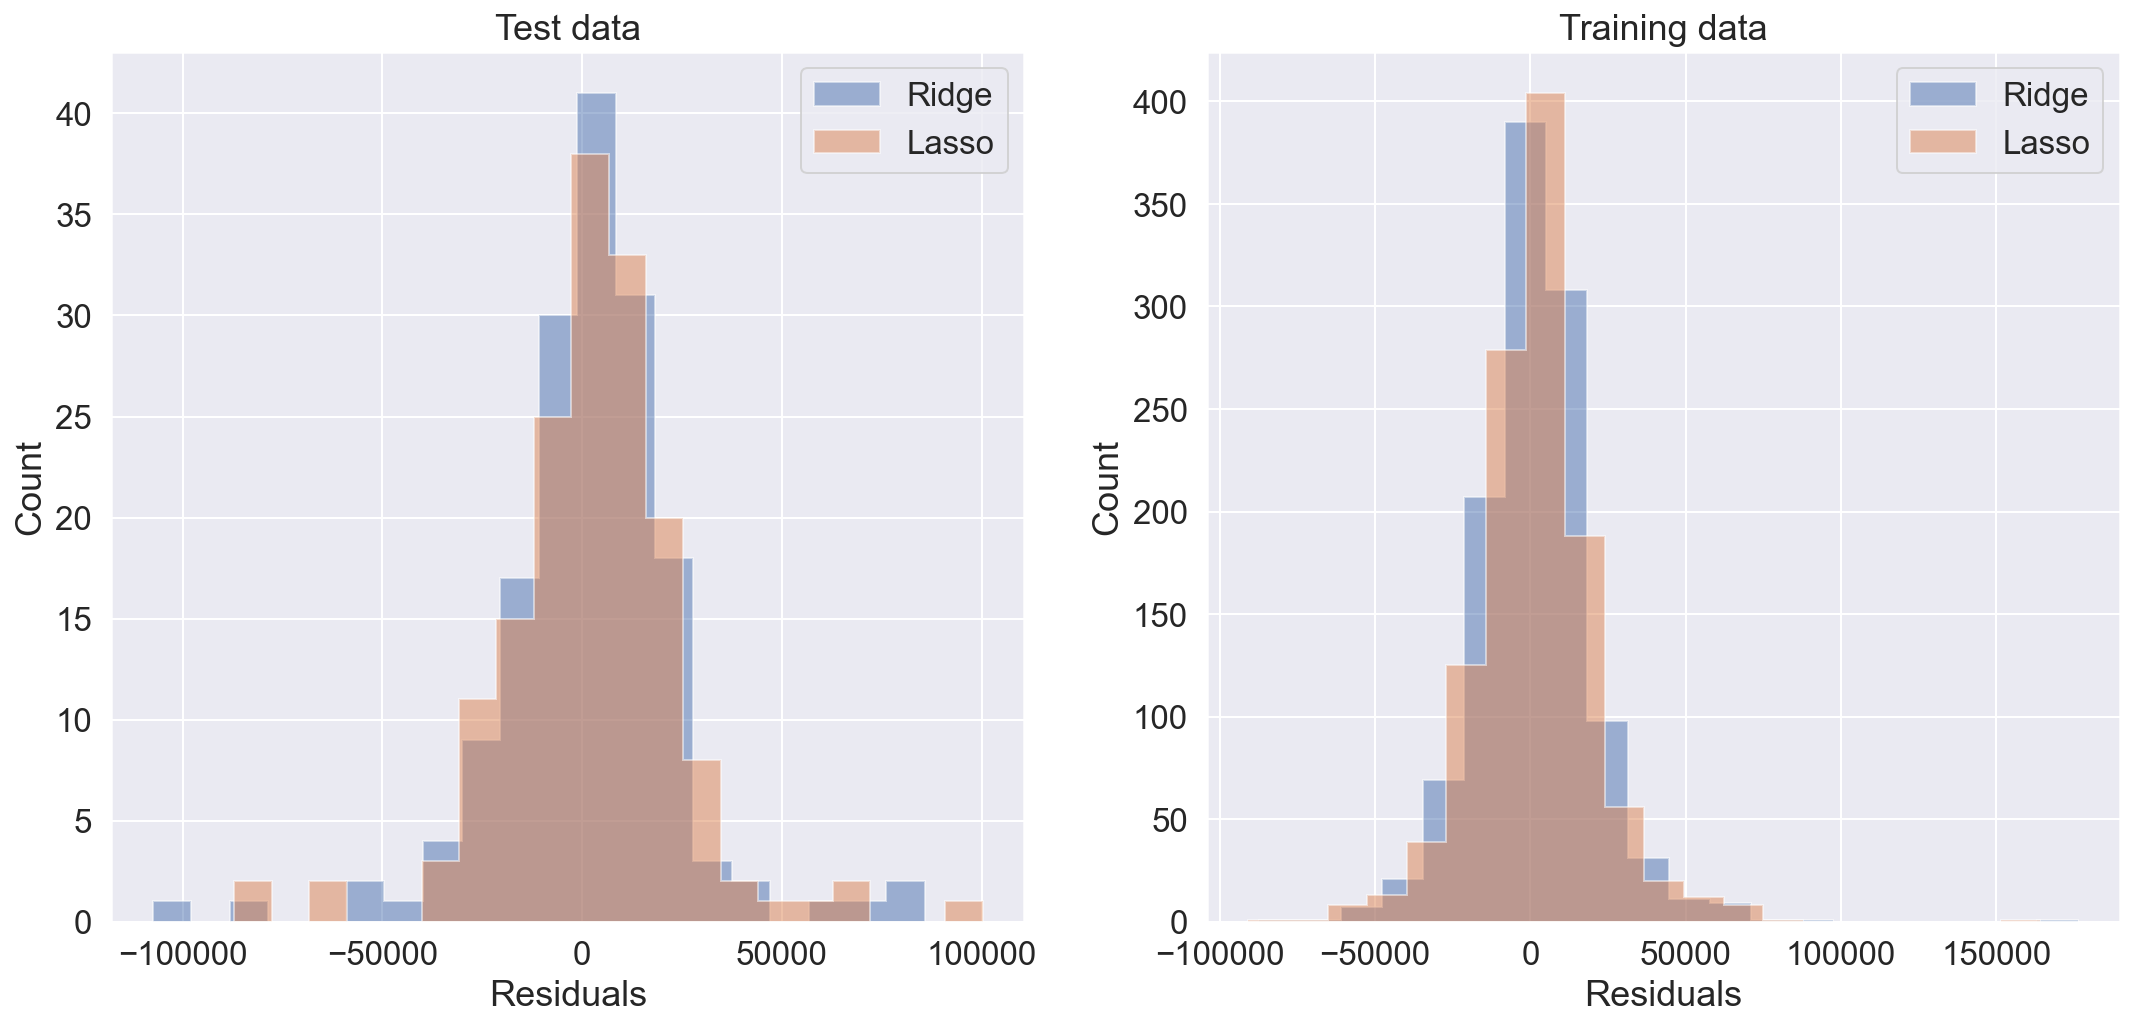

In [32]:
# plot the residuals
fig, ax = plt.subplots(ncols=2, figsize=(18, 8))
ax[0].hist(ridge_residuals_1, bins=20, histtype='stepfilled', alpha=0.5)
ax[0].hist(lasso_residuals_1, bins=20, histtype='stepfilled', alpha=0.5)
ax[0].set_title('Test data')
ax[1].hist(ridge_residuals_training_1, bins=20, histtype='stepfilled', alpha=0.5)
ax[1].hist(lasso_residuals_training_1, bins=20, histtype='stepfilled', alpha=0.5)
ax[1].set_title('Training data')

for a in ax:
    a.legend(['Ridge', 'Lasso'])
    a.set_xlabel('Residuals')
    a.set_ylabel('Count')

plt.show()

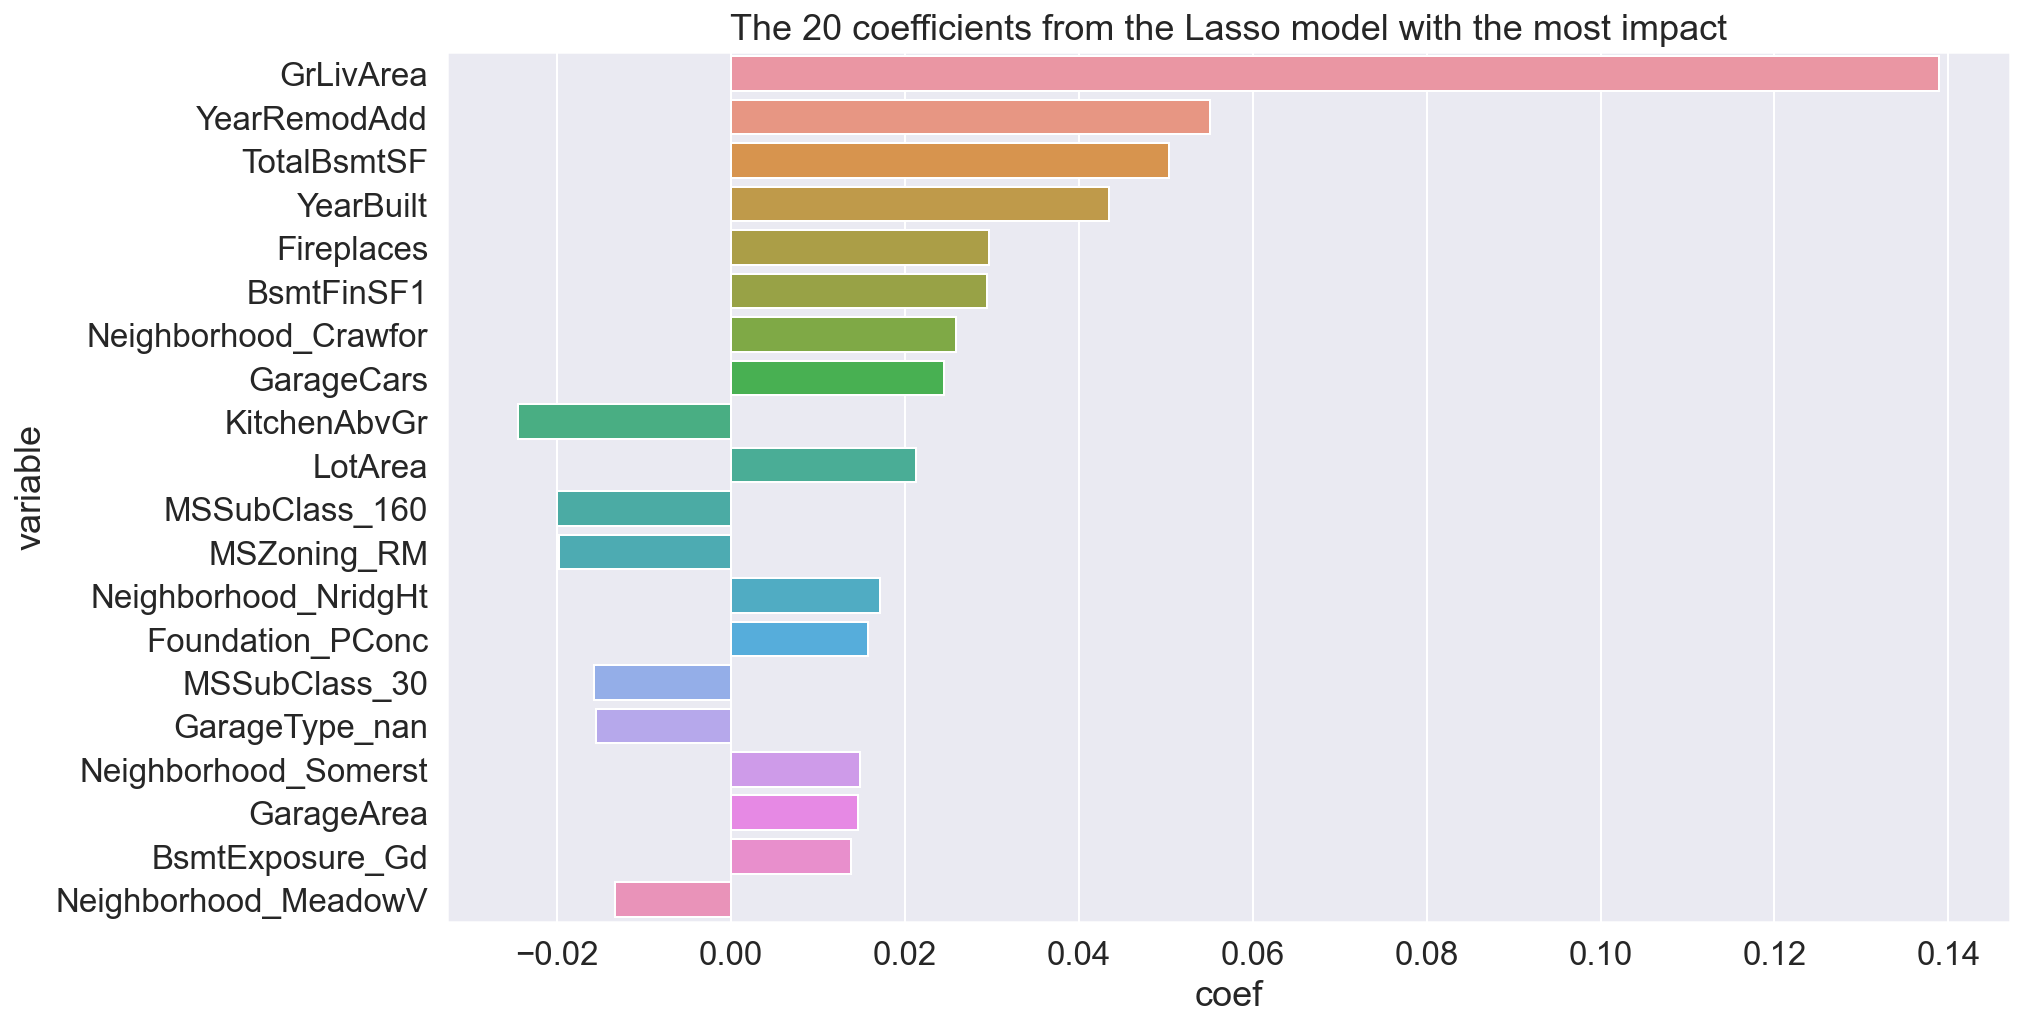

In [33]:
# plot coefficients from Lasso model
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_coef_l1.sort_values('coef_abs', ascending=False).head(20), x='coef', y='variable')
plt.title('The 20 coefficients from the Lasso model with the most impact')
plt.show()

### Conclusions
The Ridge, Lasso and ElasticNet models perform well, particularly at the lower end of the price scale where most of the data points are. Above this level, there are far fewer data points and the residuals are higher. 

Overall the Lasso model with a log transformation of the target variable is the best at predicting the price, with the highest mean cross-validated R^2 score of 0.904. The residuals appear to be normally distributed with a mean close to zero.

The predictors which have the most impact on the predicted price (from the Lasso model) are:
- *GrLivArea* (above ground living area square feet) - this has the largest positive effect on the price which is unsurprising given the high positive correlation seen in the heatmap above
- *YearBuilt* and *YearRemodAdd* both have a large positive effect on the price
- *TotalBsmtSF* (total basement square feet) also has a large positive effect on the price
- *Fireplaces* - the number of fireplaces also has a surprisingly large positive effect on the price. It does have a reasonable positive correlation with the sale price as well as the GrLivArea.
- *KitchenAbvGr* - the number of kitchens above ground has the largest negative effect on the price. This is a bit surprising as 95% of instances have number of kitchens=1. It might be worth investigating removing this variable.
- The neighbourhood also has an impact on the price - some increase it and some decrease it as you would expect.
- *LotArea* and *GarageCars* also both have a positive impact on the price as expected
- *GarageType_nan* - not having a garage reduces the sale price

In [34]:
df.KitchenAbvGr.value_counts(normalize=True)

1    0.954230
2    0.043689
3    0.001387
0    0.000693
Name: KitchenAbvGr, dtype: float64

### Part 2: Modelling - Renovateable Features

In [35]:
# dummify categorical variables including NaN as a category
X_2 = pd.get_dummies(df_1[renovateable_features], dummy_na=True, drop_first=True)
X_2.shape

(1320, 126)

In [36]:
# get train-test split
X_2_train = pd.DataFrame(X_2[df_1.YrSold < 2010], columns=X_2.columns)
X_2_test = pd.DataFrame(X_2[df_1.YrSold == 2010], columns=X_2.columns)
y_2_train = lasso_residuals_training_1
y_2_test = lasso_residuals_1
X_2_train.shape, X_2_test.shape, y_2_train.shape, y_2_test.shape

((1156, 126), (164, 126), (1156,), (164,))

In [37]:
# standardize the data
scaler = StandardScaler()
X_2_train = pd.DataFrame(scaler.fit_transform(X_2_train), columns=X_2_train.columns)
X_2_test = pd.DataFrame(scaler.transform(X_2_test), columns=X_2_test.columns)

### Linear regression model

In [38]:
lr_2 = LinearRegression()
lr_2_scores = useful_functions.model_fitter(lr_2, X_2_train, y_2_train, X_2_test, y_2_test, cv=kf)

Mean cross-validated training score:  -1.354202485605472e+27
Training score:  0.41916653009502103
Test score:  -3.5469594018048897e+22


### Comment on linear regression model
As in part 1, the Linear Regression model does not perform well, giving very large negative R^2 scores. Regularization is needed - look at Ridge, Lasso and ElasticNet models.

### Ridge model

In [39]:
# find optimal value for alpha in Ridge model
optimal_ridge_2 = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)
optimal_ridge_2.fit(X_2_train, y_2_train)
print(optimal_ridge_2.alpha_)

108.43659686896109


In [40]:
ridge_2 = Ridge(alpha=optimal_ridge_2.alpha_)                                    
ridge_2_scores = useful_functions.model_fitter(ridge_2, X_2_train, y_2_train, X_2_test, y_2_test, cv=kf)

Mean cross-validated training score:  0.2247235622036224
Training score:  0.37716542749466775
Test score:  0.13662034104066234


### Lasso model

In [41]:
# find optimal value for alpha in Lasso model
optimal_lasso_2 = LassoCV(n_alphas=500, cv=10, n_jobs=-2, max_iter=50000)
optimal_lasso_2.fit(X_2_train, y_2_train)
print(optimal_lasso_2.alpha_)

115.2594225629653


In [42]:
lasso_2 = Lasso(alpha=optimal_lasso_2.alpha_)
lasso_2_scores = useful_functions.model_fitter(lasso_2, X_2_train, y_2_train, X_2_test, y_2_test, cv=kf)

Mean cross-validated training score:  0.23651093996114286
Training score:  0.3828119840254579
Test score:  0.14306520816602564


### ElasticNet model

In [43]:
# find optimal value for alpha and l1 ratio in ElasticNet model
optimal_en_2 = ElasticNetCV(alphas=np.logspace(-5, 5, 10), 
                          l1_ratio=np.array([0.00001, .1, .5, .7, .9, .95, .99, 1]), 
                          cv=5, max_iter=1000000, n_jobs=-2)
optimal_en_2.fit(X_2_train, y_2_train)
print("Best alpha: ", optimal_en_2.alpha_)
print("Best l1 ratio: ", optimal_en_2.l1_ratio_)

/Users/julia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92694158994.71649, tolerance: 34617663.39755103
  model = cd_fast.enet_coordinate_descent_gram(
/Users/julia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90078929987.29192, tolerance: 34425490.61402241
  model = cd_fast.enet_coordinate_descent_gram(
/Users/julia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89950862665.88936, tolerance: 36524928.73603439
  model = cd_fast.enet_coordinate_descent_gram(
/Users/julia/opt/anaconda3/lib/python3.8/site-packages/skl

Best alpha:  599.4842503189421
Best l1 ratio:  1.0


In [44]:
enet_2 = ElasticNet(alpha=optimal_en_2.alpha_, l1_ratio=optimal_en_2.l1_ratio_)
enet_2_scores = useful_functions.model_fitter(enet_2, X_2_train, y_2_train, X_2_test, y_2_test, cv=kf)

Mean cross-validated training score:  0.21632170386830504
Training score:  0.308478836448298
Test score:  0.11345272700855713


### Results

In [45]:
# collect scores in a DataFrame
df_scores_2 = pd.DataFrame([ridge_2_scores, lasso_2_scores, enet_2_scores], 
                           columns=['Mean CV score', 'Training score', 'Test score'])
df_scores_2.insert(0, 'Model', ['Ridge', 'Lasso', 'ElasticNet'])
df_scores_2

,Model,Mean CV score,Training score,Test score
0,Ridge,0.224724,0.377165,0.136620
1,Lasso,0.236511,0.382812,0.143065
2,ElasticNet,0.216322,0.308479,0.113453


The Ridge, Lasso and ElasticNet models  all give similar cross-validated training scores which are higher than the baseline score of zero, but not very high. The results are summarized in the DataFrame above. Overall, the Lasso model has the highest mean cross-validated R^2 score and the highest R^2 score on the test data.

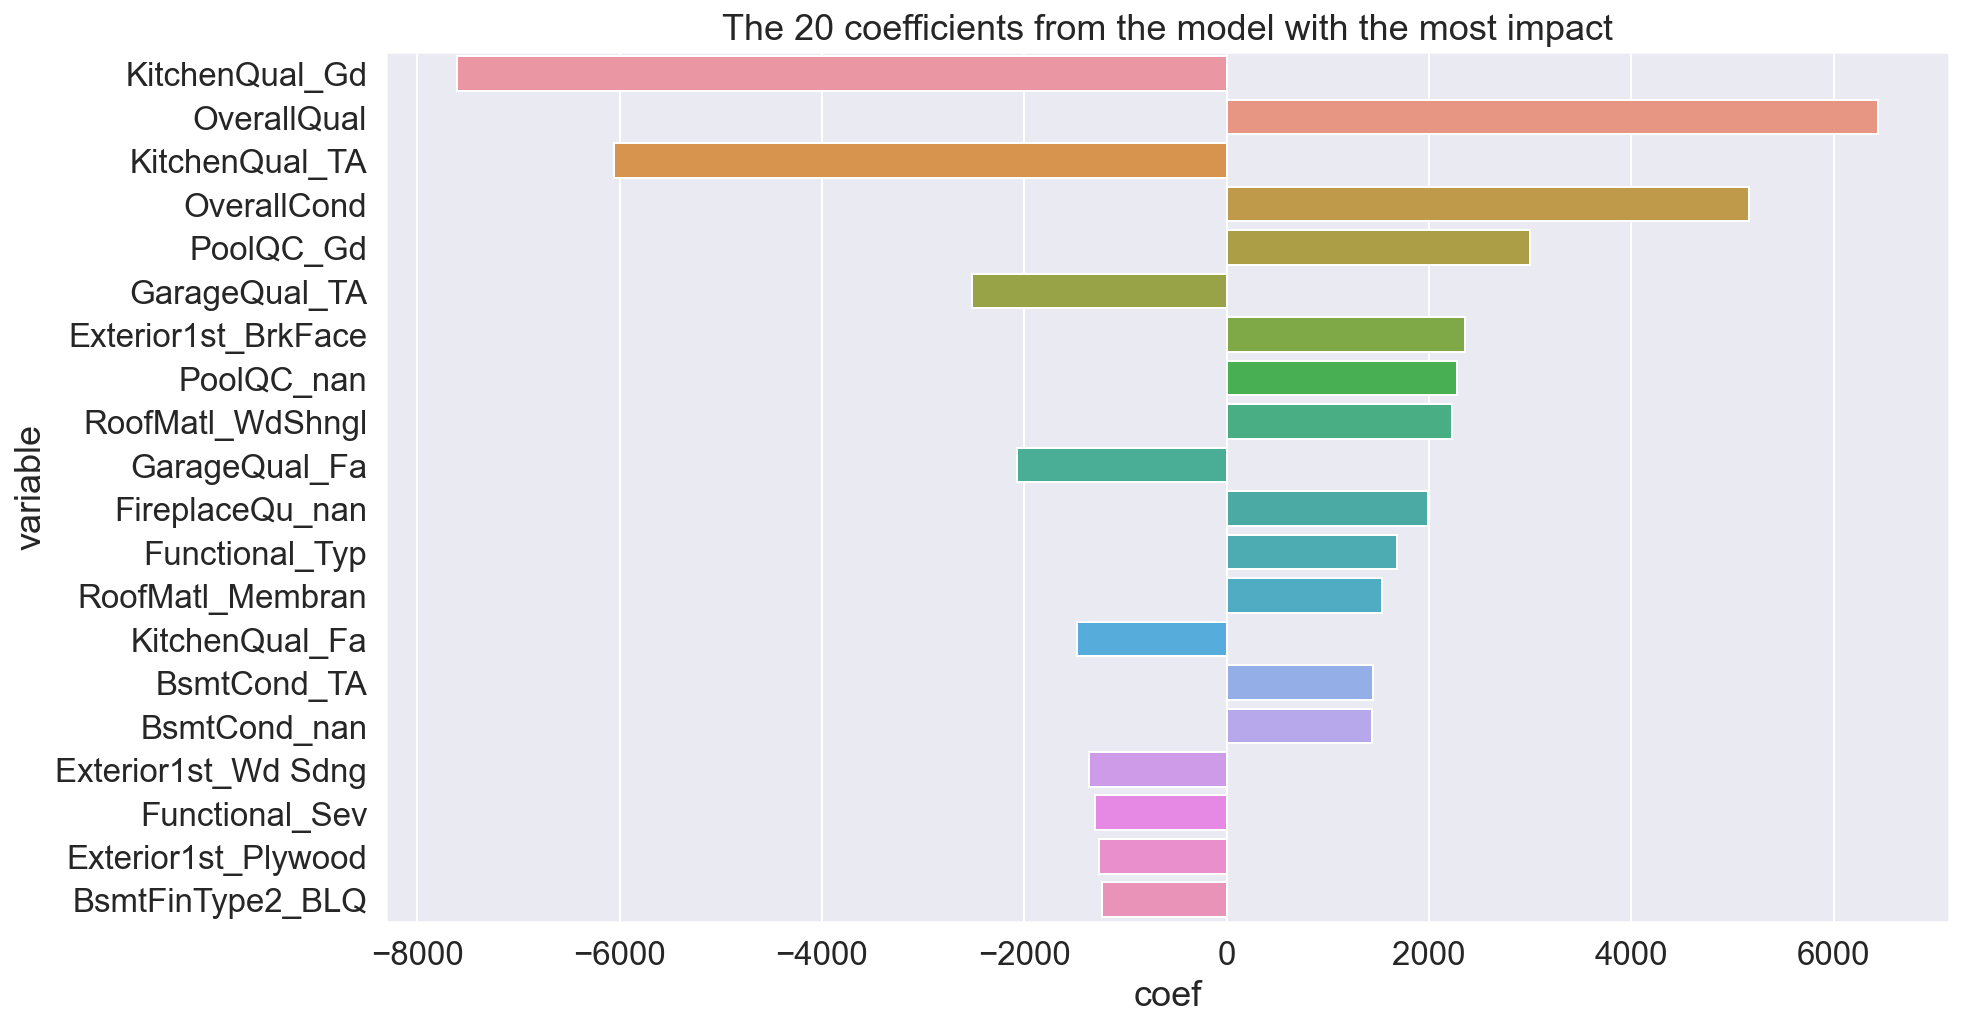

In [46]:
# plot model coefficients for Lasso model
df_coef_l2, fig_l2 = useful_functions.plot_coefficients(lasso_2, X_2.columns, n_to_plot=20)

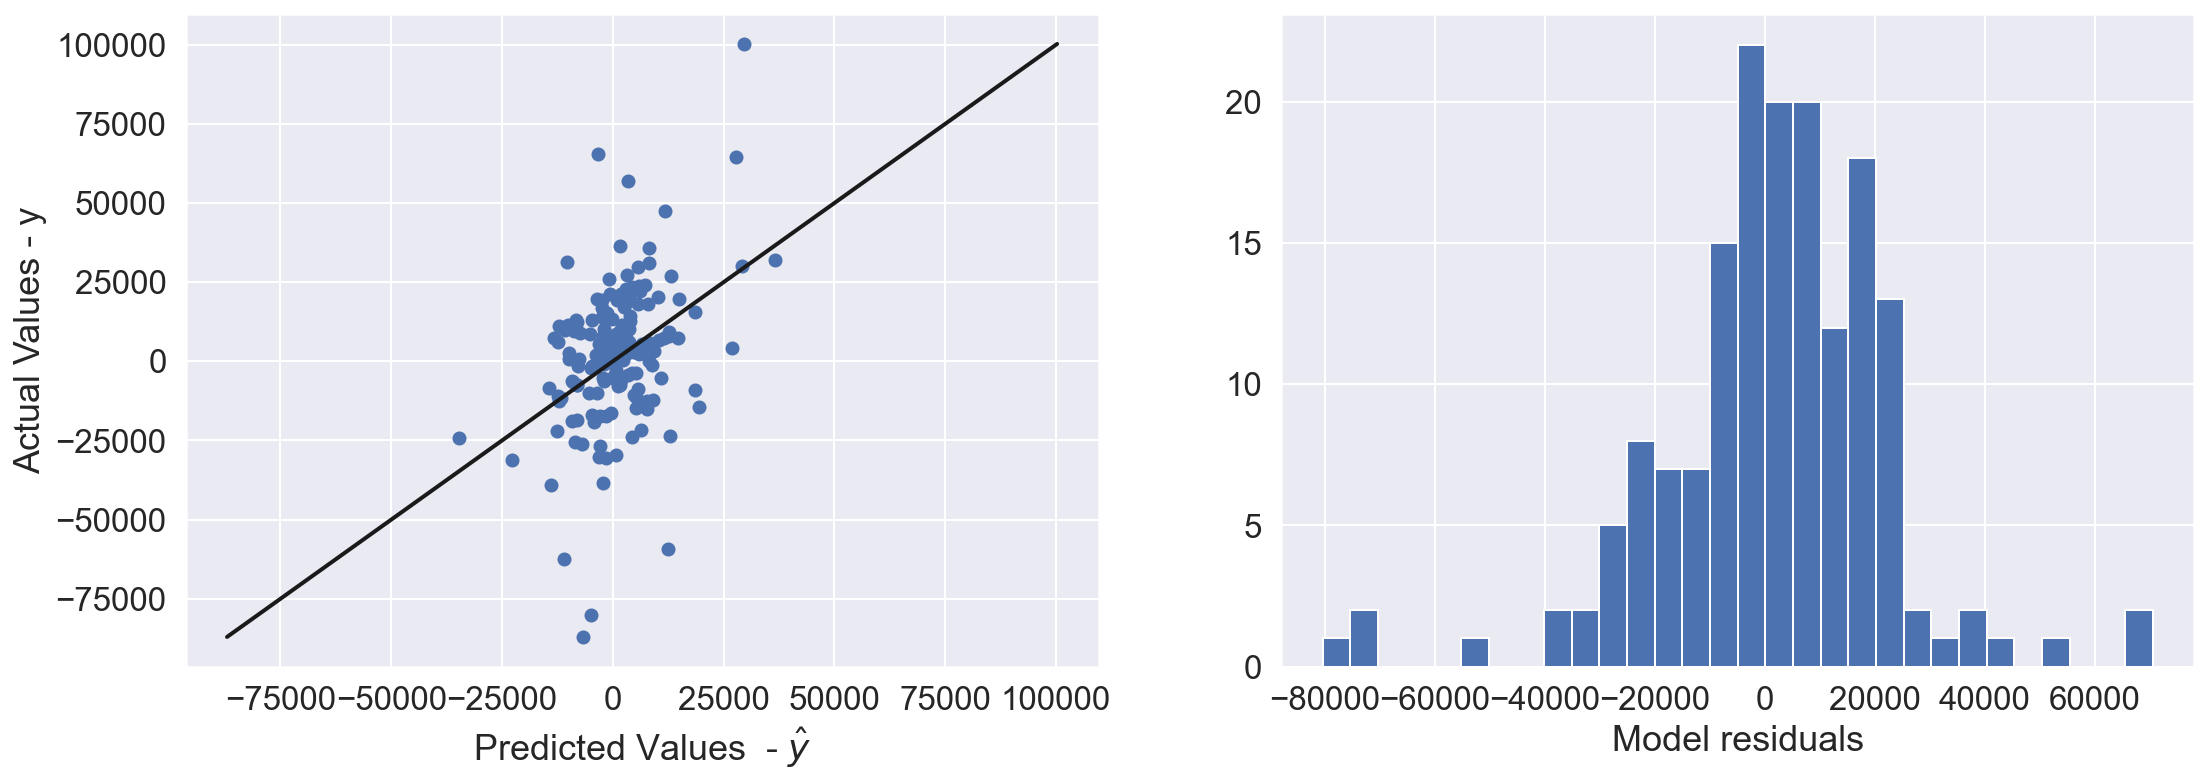

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
# plot Lasso model actual vs predictions
ax[0].scatter(lasso_2.predict(X_2_test), y_2_test)
ax[0].plot([y_2_test.min(), y_2_test.max()], [y_2_test.min(), y_2_test.max()], c='k', lw=2)
ax[0].set_xlabel("Predicted Values  - $\hat{y}$")
ax[0].set_ylabel("Actual Values - y")
# plot the Lasso model residuals
lasso_residuals_2 = y_2_test - lasso_2.predict(X_2_test)
ax[1].hist(lasso_residuals_2, bins=30)
ax[1].set_xlabel('Model residuals')
plt.show()

### Conclusions

As shown above, the Lasso model gives the best results. The R^2 score of 0.237 and the test score of 0.143 are better than the baseline of zero but not high. This is perhaps not surprising given that the model in part 1 predicts the price well and this model from part 2 is trying to predict a secondary effect. The scatter plot above shows the predicted values from the Lasso model versus the actual values - the model is not good at predicting the larger values. The histogram shows the residuals of the Lasso model which appear approximately normally distributed.

The predictors which have the most impact on the price residuals are:
- *OverallCond* and *OverallQual* have large positive impacts on the price residuals which is unsurprising.
- *Functional* - the home functionality has a large effect. Typical functionality has a positive impact and Severely Damaged (Sev) has a negative impact.
- *Exterior1st* - the exterior covering on the house has a large impact. Brick Face (BrkFace) has a positive impact and Wood Siding and Plywood both have a negative impact. 
- *KitchenQual_Gd* and *KitchenQual_TA*, kitchen quality of good and typical/average (versus the best category of Excellent), both have a large negative impact. This implies that renovating the kitchen if required could have a positive effect on the overall house price.

### Calculate predicted prices based on fixed and renovateable features

In [48]:
# use models from part 1 and part 2 to estimate final price
# use Lasso models for both parts 1 and 2, as they have the highest mean cross-validated scores
# final price = price from fixed features model + price from renovateable features model + residuals
predictions_fixed = lasso_1_log.predict(X_1_test)
predictions_renovateable = lasso_2.predict(X_2_test)
predicted_prices = predictions_fixed + predictions_renovateable

In [49]:
# calculate R^2 score on the combined models
RSS = sum((y_1_test - predicted_prices)**2)
TSS = sum((y_1_test - y_1_test.mean())**2)
final_score = 1 - RSS/TSS
print('R^2 score on the combined models (test data): ', final_score)

R^2 score on the combined models (test data):  0.9094931299838276


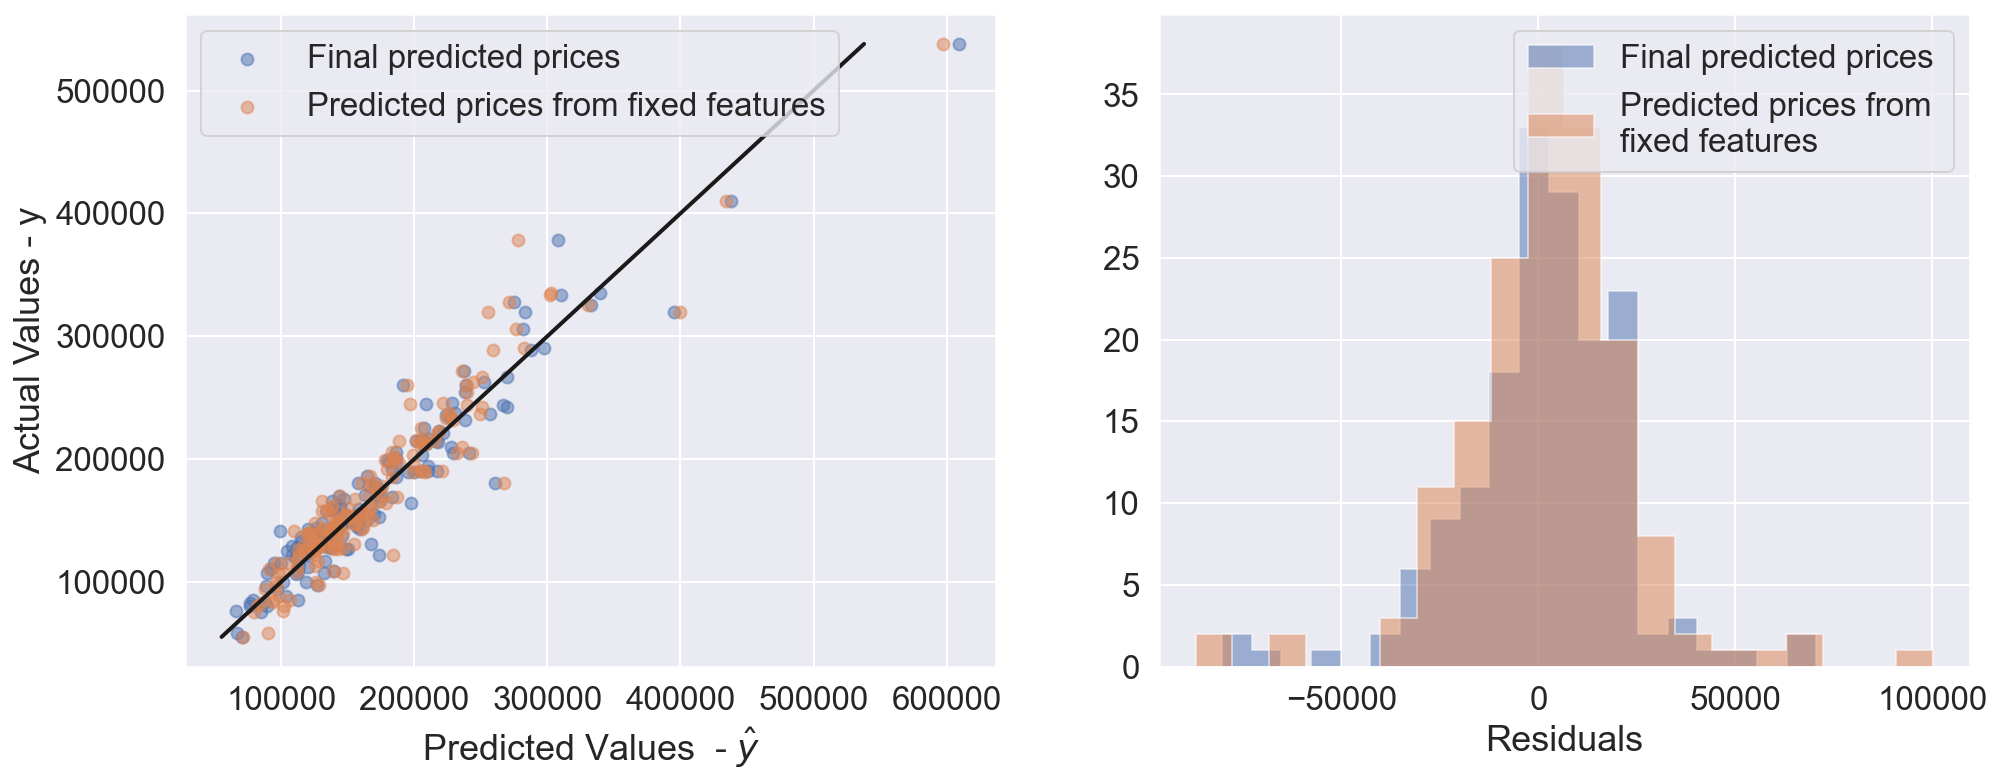

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
# plot actual vs predictions for final predicted price
ax[0].scatter(predicted_prices, y_1_test, alpha=0.5)
ax[0].scatter(predictions_fixed, y_1_test, alpha=0.5)
ax[0].legend(['Final predicted prices', 'Predicted prices from fixed features'])
ax[0].plot([y_1_test.min(), y_1_test.max()], [y_1_test.min(), y_1_test.max()], c='k', lw=2)
ax[0].set_xlabel("Predicted Values  - $\hat{y}$")
ax[0].set_ylabel("Actual Values - y")
# plot the residuals for final predicted price
residuals_final = y_1_test - predicted_prices
ax[1].hist(residuals_final, bins=20, histtype='stepfilled', alpha=0.5)
ax[1].hist(lasso_residuals_1, bins=20, histtype='stepfilled', alpha=0.5)
ax[1].legend(['Final predicted prices', 'Predicted prices from \nfixed features'])
ax[1].set_xlabel('Residuals')
plt.show()

### Overall conclusions
The combined model (fixed features + renovateable features) has a R^2 score of 0.909 on the test data, compared to the R^2 score of 0.893 for the model with only the fixed features. Adding in the renovateable features does improve the overall performance of the model, but only by a small amount.

The model from part 1 scores well on the cross-validation and generalizes well on the test data. It could be used to give a good estimate of the price for a house based on its fixed features and therefore to identity good buying opportunities.   

The model from part 2 does not perform very well as discussed above, although it does improve the overall price predictions when combined with the model from part 1 (as shown by the improved R^2 score above). The coefficients determined by the model could potentially be useful to identify which features of a house to renovate to maximize the return.